In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

sns.set(rc={'figure.figsize':(9, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

from data_loader import load_data, BenchmarkType, Benchmark, System

# Load LULESH data

In [2]:
lulesh_time = load_data(BenchmarkType.BASELINE, System.DAINT_MC, Benchmark.LULESH, ranks = 64, spread = 32)
normal_lulesh = lulesh_time.loc[lulesh_time['ranks_per_node'] == 32]

avg_lulesh = normal_lulesh.groupby(['size']).mean().reset_index()
median_lulesh = normal_lulesh.groupby(['size']).median().reset_index()
dev_lulesh = normal_lulesh.groupby(['size']).std().reset_index()

# Load NAS data

In [3]:
nas_container = load_data(BenchmarkType.BASELINE, System.DAINT_MC, Benchmark.NAS)

mean_nas = nas_container.groupby(['benchmark', 'size', 'ranks']).mean().reset_index()
dev_nas = nas_container.groupby(['benchmark', 'size', 'ranks']).std().reset_index()
median_nas = nas_container.groupby(['benchmark', 'size', 'ranks']).median().reset_index()


# Load LULESH + NAS co-location data

In [16]:
path, colocated_lulesh, colocated_nas = load_data(BenchmarkType.COLOCATION_CPU, System.DAINT_MC,
                          Benchmark.LULESH, colocated_benchmark = Benchmark.NAS, ranks = 64)

avg_colocated_lulesh = colocated_lulesh.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).mean().reset_index()
median_colocated_lulesh = colocated_lulesh.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).median().reset_index()
dev_colocated_lulesh = colocated_lulesh.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).std().reset_index()

mean_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).mean().reset_index()
dev_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).std().reset_index()
median_colocated_nas = colocated_nas.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).median().reset_index()
colocated_lulesh.groupby(['size', 'colocated_benchmark','colocated_benchmark_size']).count()

repetition  time  ranks
size colocated_benchmark colocated_benchmark_size                         
15   bt                  A                                 25    25     25
                         W                                 25    25     25
     cg                  B                                 25    25     25
     ep                  B                                 25    25     25
     lu                  A                                 26    26     26
     mg                  A                                 26    26     26
                         W                                 25    25     25
18   bt                  A                                 25    25     25
                         W                                 23    23     23
     cg                  B                                 23    23     23
     ep                  B                                 25    25     25
     lu                  A                                 25    25     25
     mg                  A                                 26    26     26
                         W                                 24    24     24
20   bt                  A                                 23    23     23
                         W                                 25    25     25
     cg                  B                                 26    26     26
     ep                  B                                 23    23     23
     lu                  A                                 25    25     25
     mg                  A                                 25    25     25
                         W                                 23    23     23
25   bt                  A                                 23    23     23
                         W                                 22    22     22
     cg                  B                                 23    23     23
     ep                  B                                 22    22     22
     lu                  A                                 23    23     23
     mg                  A                                 25    25     25
                         W                                 21    21     21

# Compute slowdown data

In [5]:

#df1['dev'] = df4['time'].reindex(df1.index)
#df1['original_time'] = df2['time'].reindex(df1.index)
#df1['original_dev'] = df3['time'].reindex(df1.index)
#df1['slowdown'] = df1['time'] / df1['original_time']

#df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

#df3 = mean_colocated_nas.set_index(['benchmark', 'size', 'p'])
#print(df3)
#df4 = mean_nas.set_index(['benchmark', 'size', 'p'])
#df10 = dev_nas.set_index(['benchmark', 'size', 'p'])
#df11 = dev_colocated_nas.set_index(['benchmark', 'size', 'p'])
#print(df4)
#df3['original_dev'] = df10['time'].reindex(df3.index)
#df3['original_time'] = df4['time'].reindex(df3.index)
#df3['slowdown'] = df3['time'] / df3['original_time']
#df3['dev'] = df11['time'].reindex(df3.index)
#df3['slowdown_dev'] = np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)

df1 = avg_lulesh.set_index('size')
df2 = dev_lulesh.set_index('size')
df4 = dev_colocated_lulesh.set_index('size')
final_lulesh_result = avg_colocated_lulesh.set_index('size')

# Compute slowdown of the LULESH 
final_lulesh_result['original_time'] = df1['time'].reindex(final_lulesh_result.index)
final_lulesh_result['original_dev'] = df2['time'].reindex(final_lulesh_result.index)
final_lulesh_result['dev'] = df4['time'].reindex(final_lulesh_result.index)
final_lulesh_result['slowdown'] = final_lulesh_result['time'] / final_lulesh_result['original_time']
final_lulesh_result['slowdown_dev'] = np.sqrt(
    (final_lulesh_result['original_dev'] / final_lulesh_result['original_time'])**2 +
    (final_lulesh_result['dev'] / final_lulesh_result['time'])**2
)

# Compute slowdown of NAS

df1 = mean_nas.set_index(['benchmark', 'size', 'ranks'])
df2 = dev_nas.set_index(['benchmark', 'size', 'ranks'])
df4 = dev_colocated_nas.set_index(['benchmark', 'size', 'ranks'])
final_nas_result = mean_colocated_nas.set_index(['benchmark', 'size', 'ranks'])

final_nas_result['original_dev'] = df2['time'].reindex(final_nas_result.index)
final_nas_result['original_time'] = df1['time'].reindex(final_nas_result.index)
final_nas_result['slowdown'] = final_nas_result['time'] / final_nas_result['original_time']
final_nas_result['dev'] = df4['time'].reindex(final_nas_result.index)
final_nas_result['slowdown_dev'] = np.sqrt(
    (final_nas_result['original_dev'] / final_nas_result['original_time'])**2 +
    (final_nas_result['dev'] / final_nas_result['time'])**2
)

# Rename columns to avoid conflicts

final_lulesh_result.reset_index(inplace=True)
#final_lulesh_result.rename(columns={"size": "lulesh_size"}, inplace=True)
final_nas_result.reset_index(inplace=True)
#final_nas_result.rename(columns={"size": "benchmark_size"}, inplace=True)

# Set a common index

final_lulesh_result.set_index(['colocated_benchmark', 'colocated_benchmark_size', 'size'], inplace=True)
final_nas_result.set_index(['benchmark', 'size', 'batch_benchmark_size'], inplace=True)

# Transport NAS data to the Pandas dataframe with LULESH results

final_lulesh_result['nas_slowdown'] = final_nas_result['slowdown'].reindex(final_lulesh_result.index)
final_lulesh_result['nas_slowdown_dev'] = final_nas_result['slowdown_dev'].reindex(final_lulesh_result.index)
final_lulesh_result['nas_ranks'] = final_nas_result['ranks'].reindex(final_lulesh_result.index)

final_lulesh_result.reset_index(inplace=True)


# Sort according to NAS benchmark types

final_lulesh_result['type'] = final_lulesh_result.apply(lambda row: f"({row['colocated_benchmark'].upper()}, {row['colocated_benchmark_size']}, {row['nas_ranks']})", axis=1)
final_lulesh_result.sort_values(by=['type'], inplace=True)

# Rescale the slowdown

final_lulesh_result['rescaled_slowdown'] = (final_lulesh_result['slowdown']-1)*100
final_lulesh_result['rescaled_nas_slowdown'] = (final_lulesh_result['nas_slowdown']-1)*100
final_lulesh_result['rescaled_slowdown_dev'] = final_lulesh_result['slowdown_dev']*100
final_lulesh_result['rescaled_nas_slowdown_dev'] = final_lulesh_result['nas_slowdown_dev']*100

# Remove one very short benchmark with bad data
final_lulesh_result.drop(final_lulesh_result.loc[final_lulesh_result['type'] == '(MG, A, 1)'].index, inplace=True)

# Plot LULESH

In [6]:
def barplot_err(x, y, xerr=None, yerr=None, data=None, **kwargs):

    _data = []
    for _i in data.index:

        _data_i = pd.concat([data.loc[_i:_i]]*3, ignore_index=True, sort=False)
        _row = data.loc[_i]
        if xerr is not None:
            _data_i[x] = [_row[x]-_row[xerr], _row[x], _row[x]+_row[xerr]]
        if yerr is not None:
            _data_i[y] = [_row[y]-_row[yerr], _row[y], _row[y]+_row[yerr]]
        _data.append(_data_i)

    _data = pd.concat(_data, ignore_index=True, sort=False)

    _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)

    return _ax


/tmp/ipykernel_823341/986876060.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)


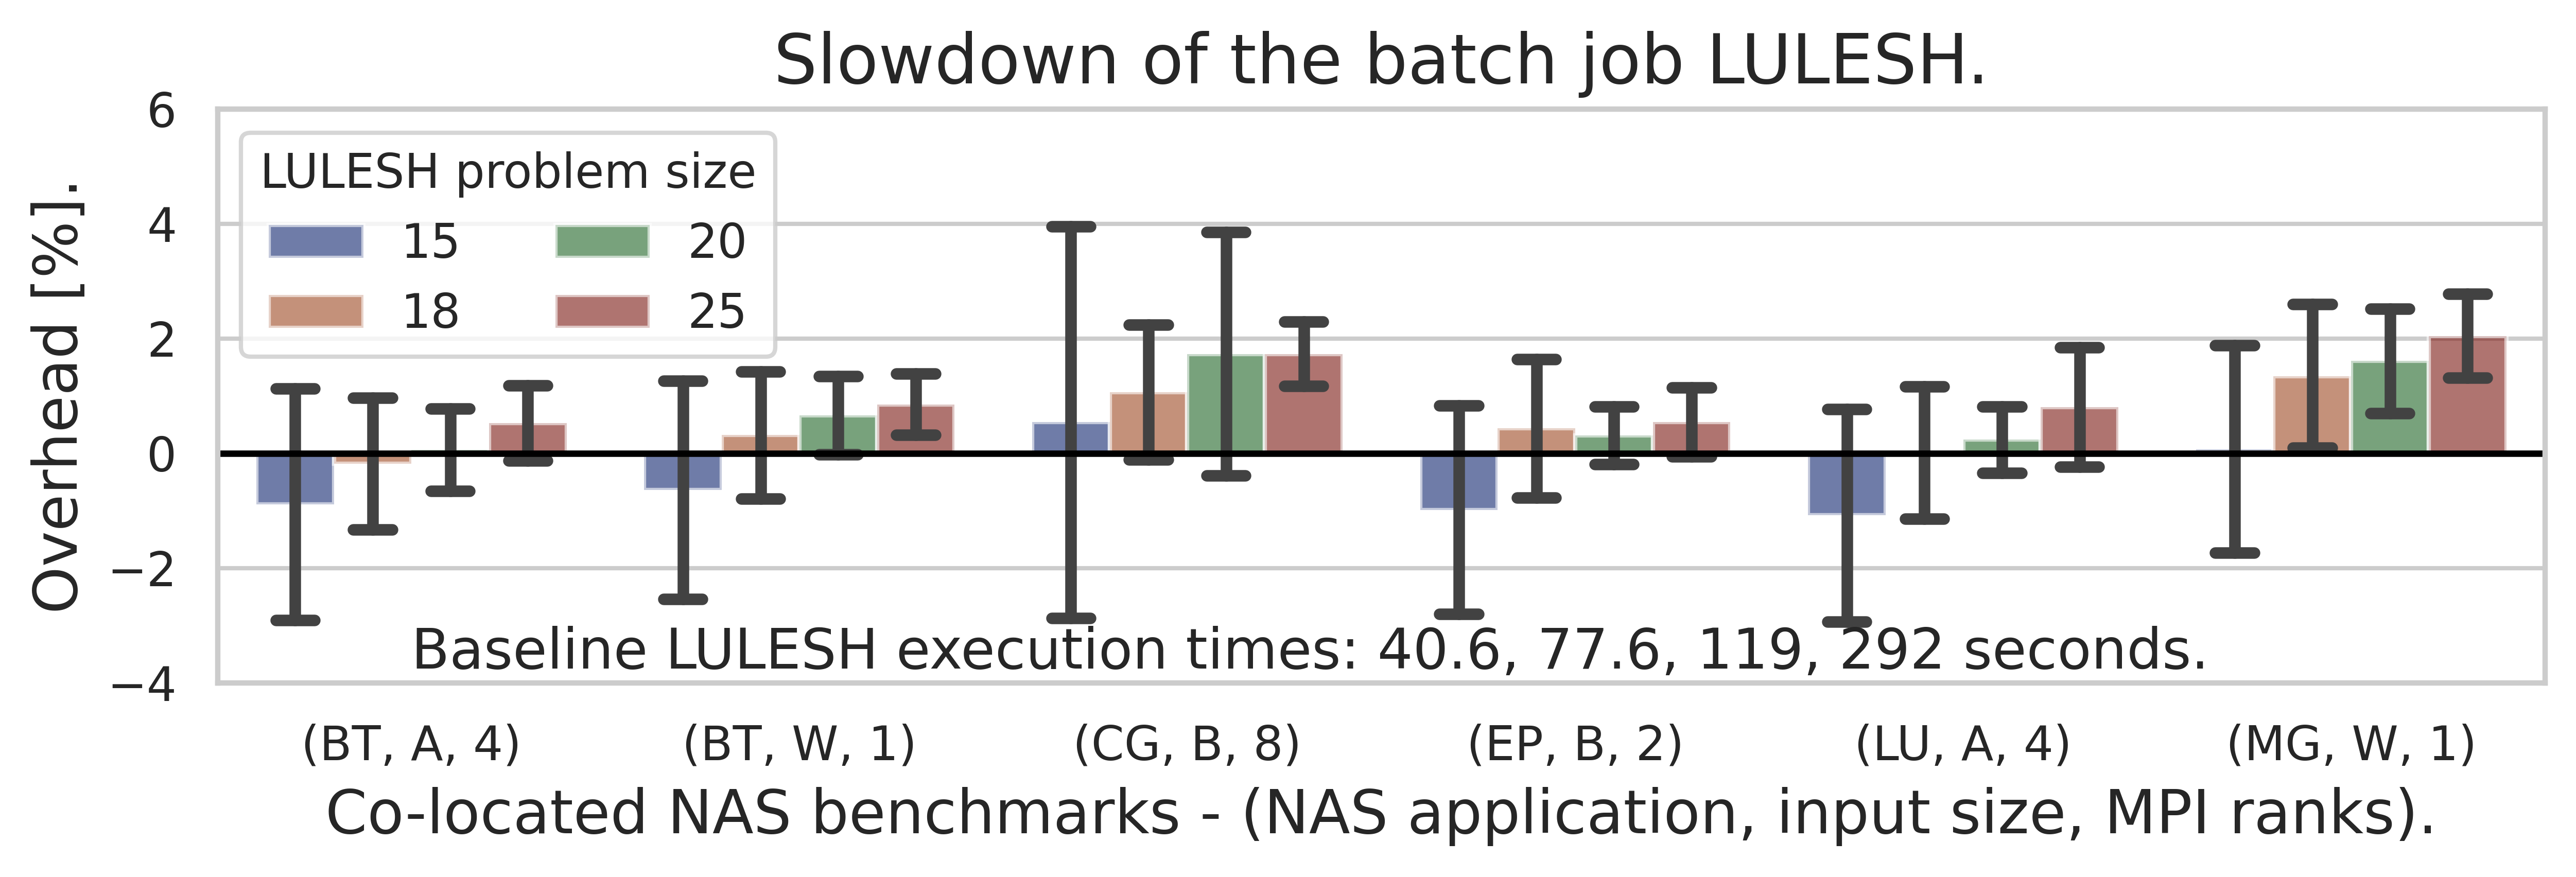

In [11]:

fig = plt.figure(figsize=(8.5,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5_modified,
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax, yerr=df5_modified['slowdown_dev']*1
#)

g = barplot_err(y="rescaled_slowdown", x="type", yerr="rescaled_slowdown_dev", hue="size",
                data=final_lulesh_result, palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located NAS benchmarks - (NAS application, input size, MPI ranks).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='LULESH problem size', ncol=2, fontsize=11,title_fontsize=11)
#plt.legend.set_title('LULESH problem size',prop={'fontsize':14})
g.set_ylim([-4,6])
g.axhline(y=0, color='black', linestyle='-')


def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    print(data)
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)
#ax.map_dataframe(errplot, "type", "slowdown", "slowdown_dev")


plt.annotate("Baseline LULESH execution times: 40.6, 77.6, 119, 292 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(0, -3.75), fontsize=13,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_cpu_lulesh.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)

/tmp/ipykernel_823341/986876060.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)


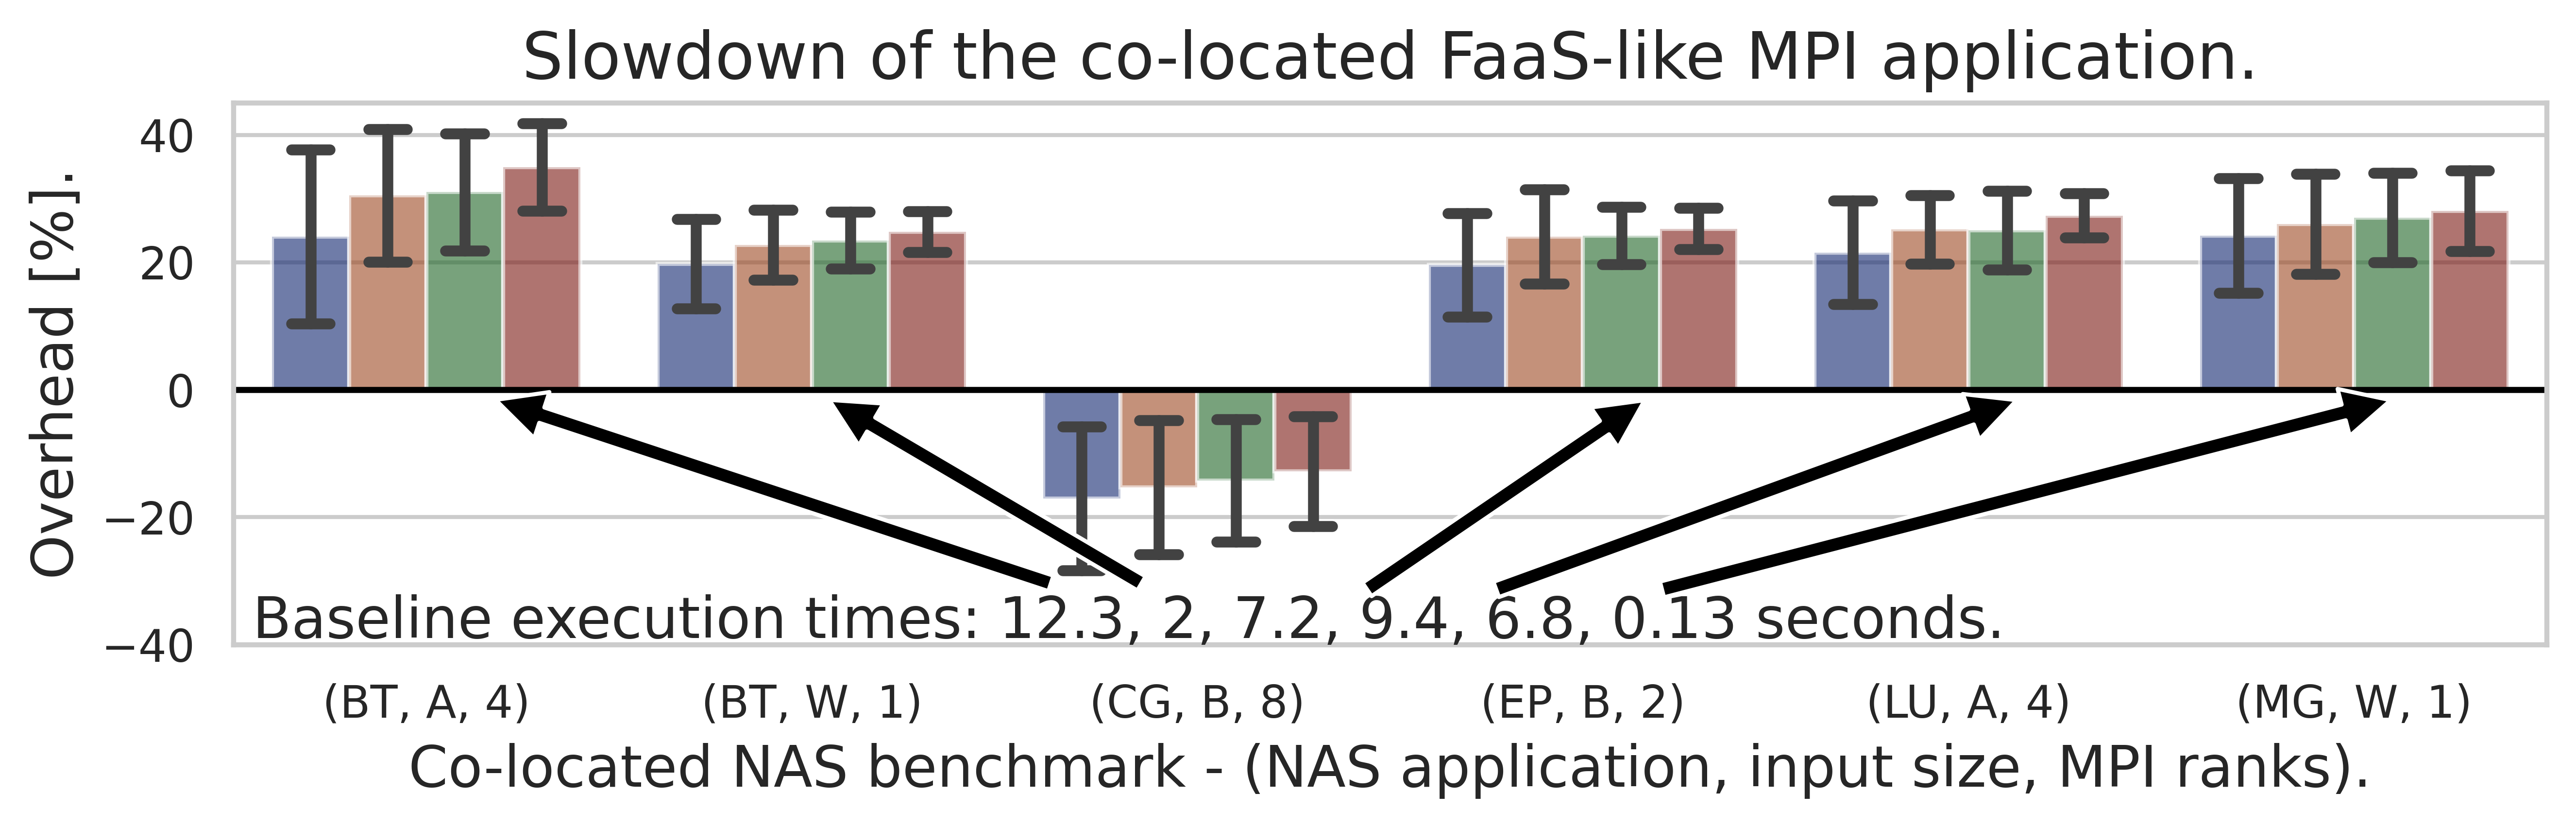

In [14]:

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df5_modified,
#    x="type", y="nas_slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #, alpha=.6, height=6,
#    ax=ax
#)
g = barplot_err(y="rescaled_nas_slowdown", x="type", yerr="rescaled_nas_slowdown_dev",
                hue="size", data=final_lulesh_result,palette="dark", alpha=.6, capsize=0.1)

g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the co-located FaaS-like MPI application.',fontsize=16)
g.legend().set_visible(False)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-40, 45])
g.set_xlabel('Co-located NAS benchmark - (NAS application, input size, MPI ranks).',fontsize=14)


plt.annotate("Baseline execution times: 12.3, 2, 7.2, 9.4, 6.8, 0.13 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(-0.45, -39), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(0.1, 0),  #xycoords='data',
            xytext=(1.7, -32),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(1, 0),  #xycoords='data',
            xytext=(1.9, -32),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
#plt.annotate("", xy=(2.1, -25),  #xycoords='data',
#            xytext=(2.1, -33),
#            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
#    #        , verticalalignment='top',
#)
plt.annotate("", xy=(3.2, 0),  #xycoords='data',
            xytext=(2.4, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(4.2, 0),  #xycoords='data',
            xytext=(2.7, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plt.annotate("", xy=(5.2, 0),  #xycoords='data',
            xytext=(3.1, -33),
            arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_cpu_lulesh_nas.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)

# Load MILC data

In [18]:
normal_milc_mc = load_data(BenchmarkType.BASELINE, System.DAINT_MC, Benchmark.MILC, ranks = 64, spread = 32)
normal_milc_mc['nodes'] = 2

avg_milc = normal_milc_mc.groupby(['size']).mean().reset_index()
median_milc = normal_milc_mc.groupby(['size']).median().reset_index()
dev_milc = normal_milc_mc.groupby(['size']).std().reset_index()

print(normal_milc_mc.groupby(['size']).count())

      repetition  time  ranks  ranks_per_node  system  type  application  \
size                                                                       
32            20    20     20              20      20    20           20   
64            20    20     20              20      20    20           20   
96            20    20     20              20      20    20           20   
128           20    20     20              20      20    20           20   

      nodes  
size         
32       20  
64       20  
96       20  
128      20  


# Load MILC co-location data

In [19]:
path, colocated_milc, colocated_nas_milc = load_data(BenchmarkType.COLOCATION_CPU, System.DAINT_MC,
                          Benchmark.MILC, colocated_benchmark = Benchmark.NAS, ranks = 64)

avg_colocated_milc = colocated_milc.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).mean().reset_index()
median_colocated_milc = colocated_milc.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).median().reset_index()
dev_colocated_milc = colocated_milc.groupby(['size', 'colocated_benchmark', 'colocated_benchmark_size']).std().reset_index()

mean_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).mean().reset_index()
dev_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).std().reset_index()
median_colocated_nas_milc = colocated_nas_milc.groupby(['benchmark', 'size', 'ranks', 'batch_benchmark_size']).median().reset_index()


In [20]:
print(avg_colocated_milc)

    size colocated_benchmark colocated_benchmark_size  repetition        time  \
0     32                  bt                        A   14.000000   86.003111   
1     32                  bt                        W   13.913043   86.898504   
2     32                  cg                        B   15.000000   87.449210   
3     32                  ep                        B   15.478261   87.261805   
4     32                  lu                        A   14.916667   86.052411   
5     32                  mg                        A   15.000000   86.693088   
6     32                  mg                        W   12.956522   87.129064   
7     64                  bt                        A   14.545455  161.775910   
8     64                  bt                        W   14.190476  163.487890   
9     64                  cg                        B   14.913043  167.488618   
10    64                  ep                        B   14.772727  162.850361   
11    64                  lu

# Compute slowdown data

In [21]:

df1 = avg_colocated_milc.set_index('size')
df2 = avg_milc.set_index('size')
df3 = dev_milc.set_index('size')
df4 = dev_colocated_milc.set_index('size')
df1['dev'] = df4['time'].reindex(df1.index)
df1['original_time'] = df2['time'].reindex(df1.index)
df1['original_dev'] = df3['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']

df1['slowdown_dev'] = np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)

#print(df1)
#print(df2)

df3 = mean_colocated_nas_milc.set_index(['benchmark', 'size', 'ranks'])
#print(df3)
df4 = mean_nas.set_index(['benchmark', 'size', 'ranks'])
df10 = dev_nas.set_index(['benchmark', 'size', 'ranks'])
df11 = dev_colocated_nas_milc.set_index(['benchmark', 'size', 'ranks'])
#print(df4)
df3['original_dev'] = df10['time'].reindex(df3.index)
df3['original_time'] = df4['time'].reindex(df3.index)
df3['slowdown'] = df3['time'] / df3['original_time']
df3['dev'] = df11['time'].reindex(df3.index)
df3['slowdown_dev'] = np.sqrt((df3['original_dev'] / df3['original_time'])**2 + (df3['dev'] / df3['time'])**2)
#print(df3)

df5 = df1.reset_index().rename(columns={"size": "milc_size"})
df6 = df3.reset_index().rename(columns={"size": "benchmark_size"})
#print(df6)
print(df6)
df5 = df5.set_index(['colocated_benchmark', 'colocated_benchmark_size', 'milc_size'])
df6 = df6.set_index(['benchmark', 'benchmark_size', 'batch_benchmark_size'])
print(df5)
print('-')
print(df6)

df5['nas_slowdown'] = df6['slowdown'].reindex(df5.index)
df5['nas_slowdown_dev'] = df6['slowdown_dev'].reindex(df5.index)
print(df5)
df5.reset_index(inplace=True)

p_map = {
    'bt' : {
        'A': 4,
        'W': 1
    },
    'cg': {
        'B': 8
    },
    'ep': {
        'B': 2
    },
    'lu': {
        'A': 4
    },
    'mg': {
        'A': 1,
        'W': 1
    }
}
print(df5)
df5['ranks'] = df5[['colocated_benchmark', 'colocated_benchmark_size']].apply(lambda x: p_map[x['colocated_benchmark']][x['colocated_benchmark_size']], axis=1)
#df5['p'] = p_map[df5['benchmark']][df5['bench_size']]
df5['type'] = df5.apply(lambda row: f"({row['colocated_benchmark'].upper()}, {row['colocated_benchmark_size']}, {row['ranks']})", axis=1)
df5.sort_values(by=['type'], inplace=True)
print(df5)

print(df5)
df5['rescaled_slowdown'] = (df5['slowdown']-1)*100
df5['rescaled_nas_slowdown'] = (df5['nas_slowdown']-1)*100
df5['rescaled_slowdown_dev'] = df5['slowdown_dev']*100
df5['rescaled_nas_slowdown_dev'] = df5['nas_slowdown_dev']*100
print(df5)

df5_modified = df5.drop(df5.loc[df5['type'] == '(MG, A, 1)'].index)

   benchmark benchmark_size  ranks  batch_benchmark_size  \
0         bt              A      4                    32   
1         bt              A      4                    64   
2         bt              A      4                    96   
3         bt              A      4                   128   
4         bt              W      1                    32   
5         bt              W      1                    64   
6         bt              W      1                    96   
7         bt              W      1                   128   
8         cg              B      8                    32   
9         cg              B      8                    64   
10        cg              B      8                    96   
11        cg              B      8                   128   
12        ep              B      2                    32   
13        ep              B      2                    64   
14        ep              B      2                    96   
15        ep              B      2      

# Plot MILC

In [22]:
def barplot_err(x, y, xerr=None, yerr=None, data=None, **kwargs):

    _data = []
    for _i in data.index:

        _data_i = pd.concat([data.loc[_i:_i]]*3, ignore_index=True, sort=False)
        _row = data.loc[_i]
        if xerr is not None:
            _data_i[x] = [_row[x]-_row[xerr], _row[x], _row[x]+_row[xerr]]
        if yerr is not None:
            _data_i[y] = [_row[y]-_row[yerr], _row[y], _row[y]+_row[yerr]]
        _data.append(_data_i)

    _data = pd.concat(_data, ignore_index=True, sort=False)

    _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)

    return _ax


/tmp/ipykernel_823341/986876060.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)


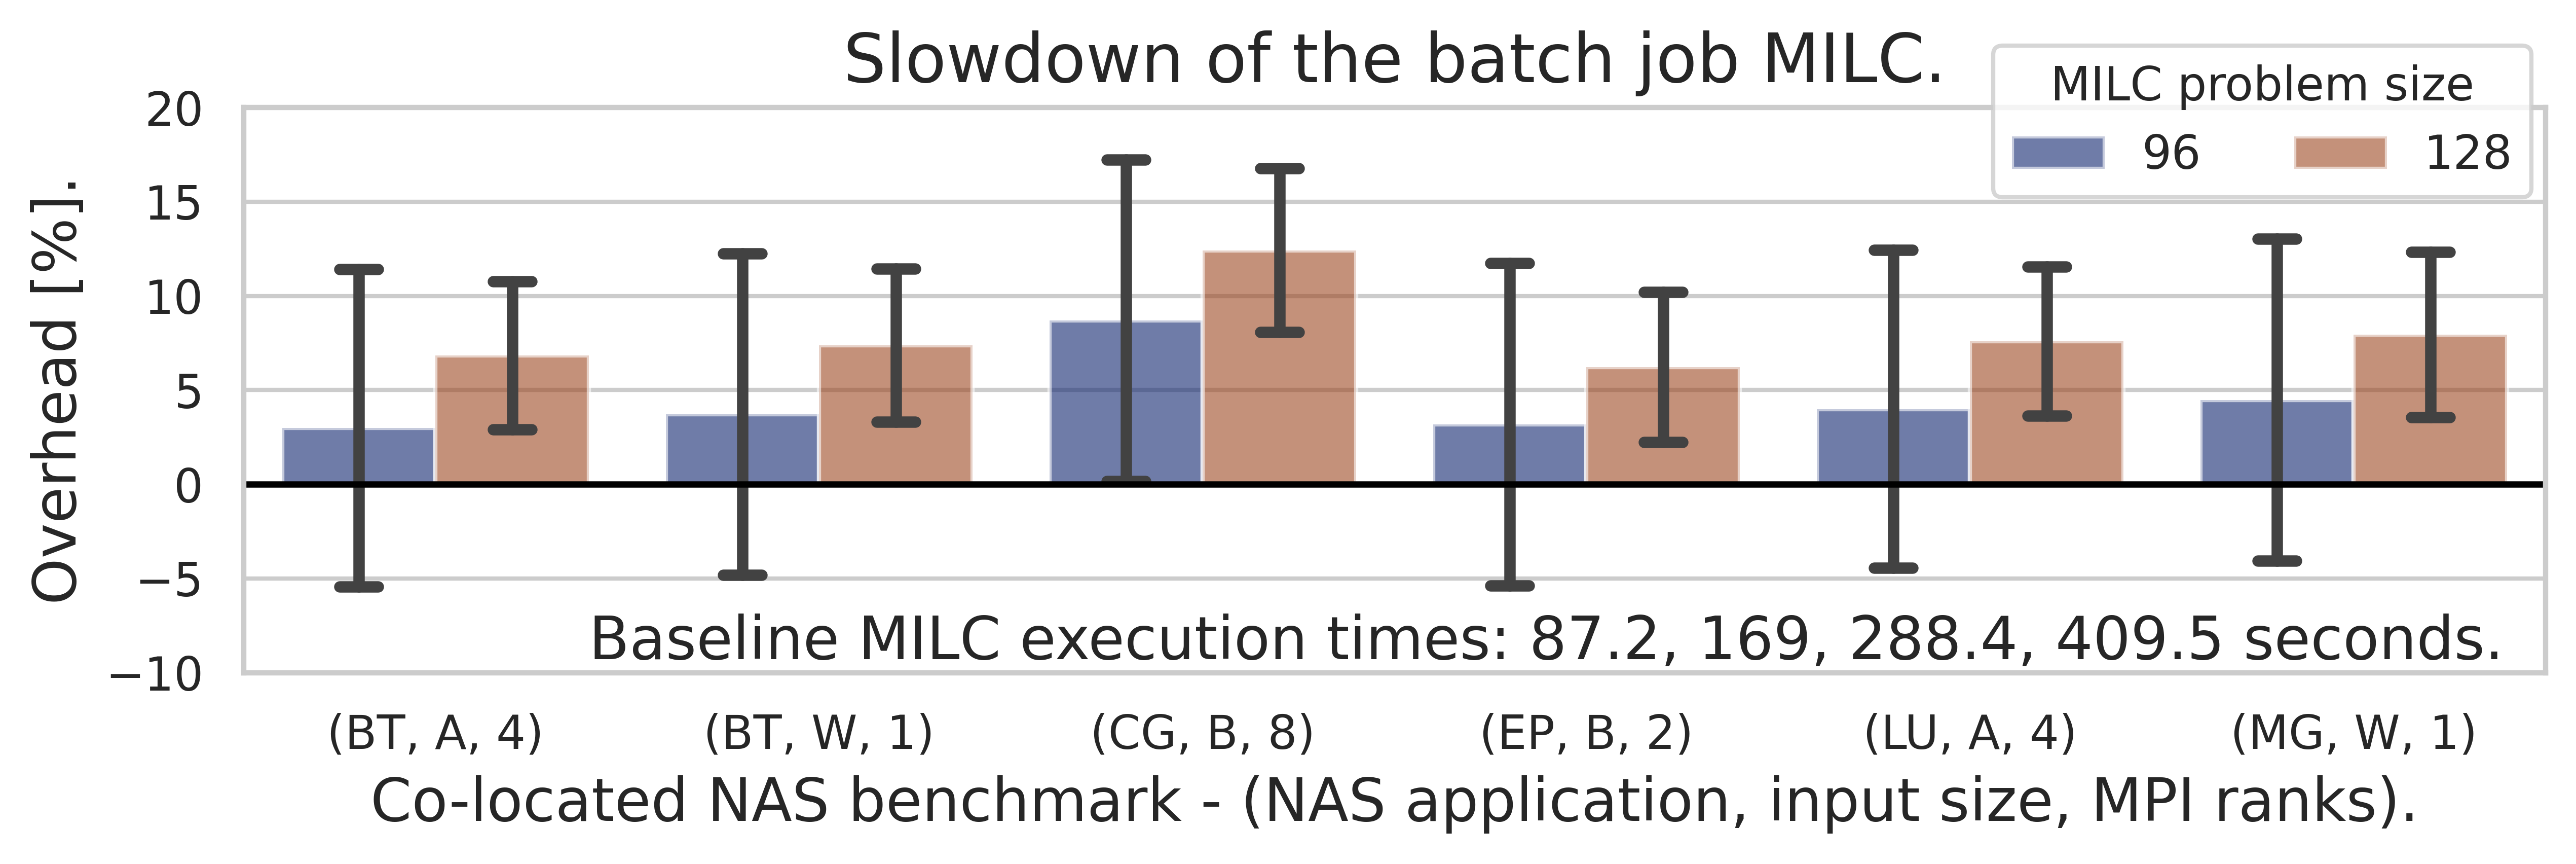

In [23]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()

g = barplot_err(y="rescaled_slowdown", x="type", yerr="rescaled_slowdown_dev", hue="milc_size",
                data=df5_modified[df5_modified['milc_size'] >= 96],palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Co-located NAS benchmark - (NAS application, input size, MPI ranks).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2, fontsize=11,title_fontsize=11, bbox_to_anchor=(0.75,0.8))
#plt.legend.set_title('LULESH problem size',prop={'fontsize':14})
g.set_ylim([-10,20])
g.axhline(y=0, color='black', linestyle='-')


plt.annotate("Baseline MILC execution times: 87.2, 169, 288.4, 409.5 seconds.",
             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
             xy=(0.5, -2),  #xycoords='data',
            xytext=(0.4, -9.3), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_cpu_milc.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)